<a href="https://colab.research.google.com/github/Raginm98/Ragin/blob/master/TS_Exogeneous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [5]:
df = pd.read_csv('/content/wind_dataset.csv')
df.shape

(6574, 9)

In [6]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)
df = df.set_index(['DATE'])
df.head()

<ipython-input-7-04c588607136>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)


,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
DATE,,,,,,,,
1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


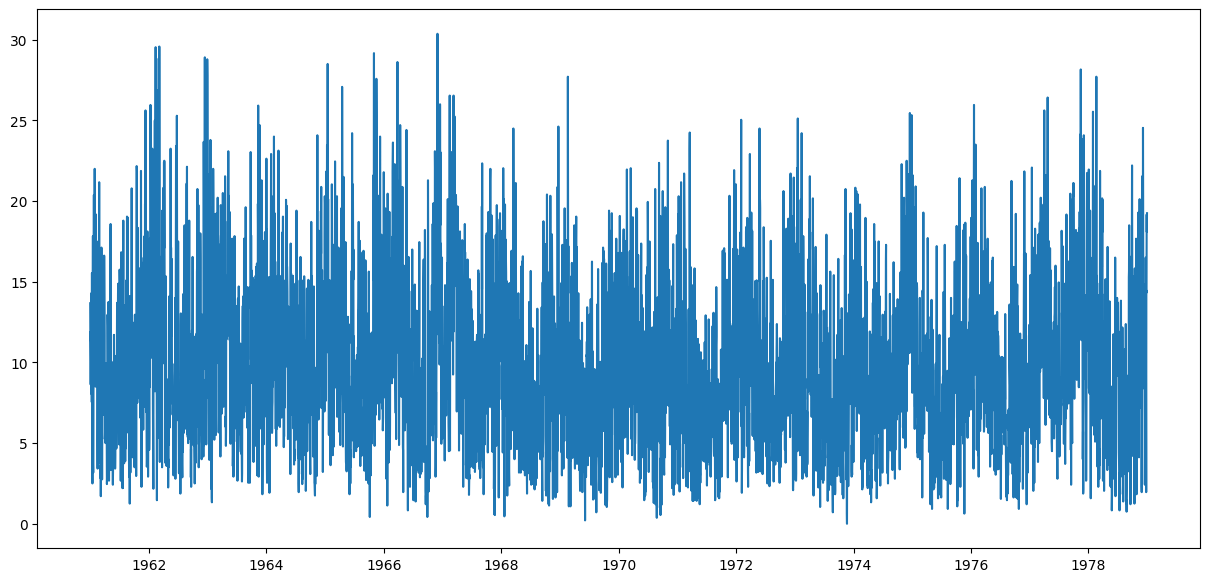

In [9]:
plt.figure(figsize=(15,7))

plt.plot(df['WIND'])
plt.show()

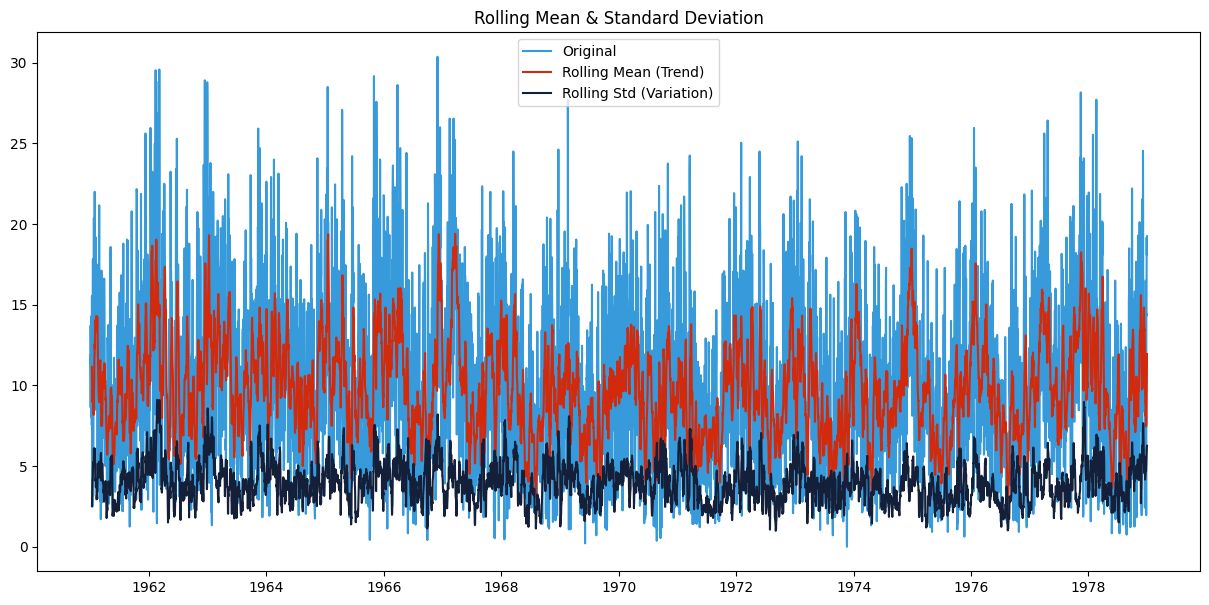

In [10]:
#Determine rolling statistics
df_copy = df.copy()
df_copy["rolling_avg"] = df_copy["WIND"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_copy["rolling_std"] = df_copy["WIND"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_copy["WIND"], color='#379BDB', label='Original')
plt.plot(df_copy["rolling_avg"], color='#D22A0D', label='Rolling Mean (Trend)')
plt.plot(df_copy["rolling_std"], color='#142039', label='Rolling Std (Variation)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Staionarity Test

In [11]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['WIND'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

if dfoutput['p-value']>0.05:
  print('Data is not stationary')
else:
  print('Data is stationary')

Results of Dickey Fuller Test:
Test Statistic                -8.413013e+00
p-value                        2.079234e-13
#Lags Used                     3.500000e+01
Number of Observations Used    6.538000e+03
Critical Value (1%)           -3.431351e+00
Critical Value (5%)           -2.861982e+00
Critical Value (10%)          -2.567005e+00
dtype: float64
Data is stationary


Text(0.5, 1.0, 'residuals')

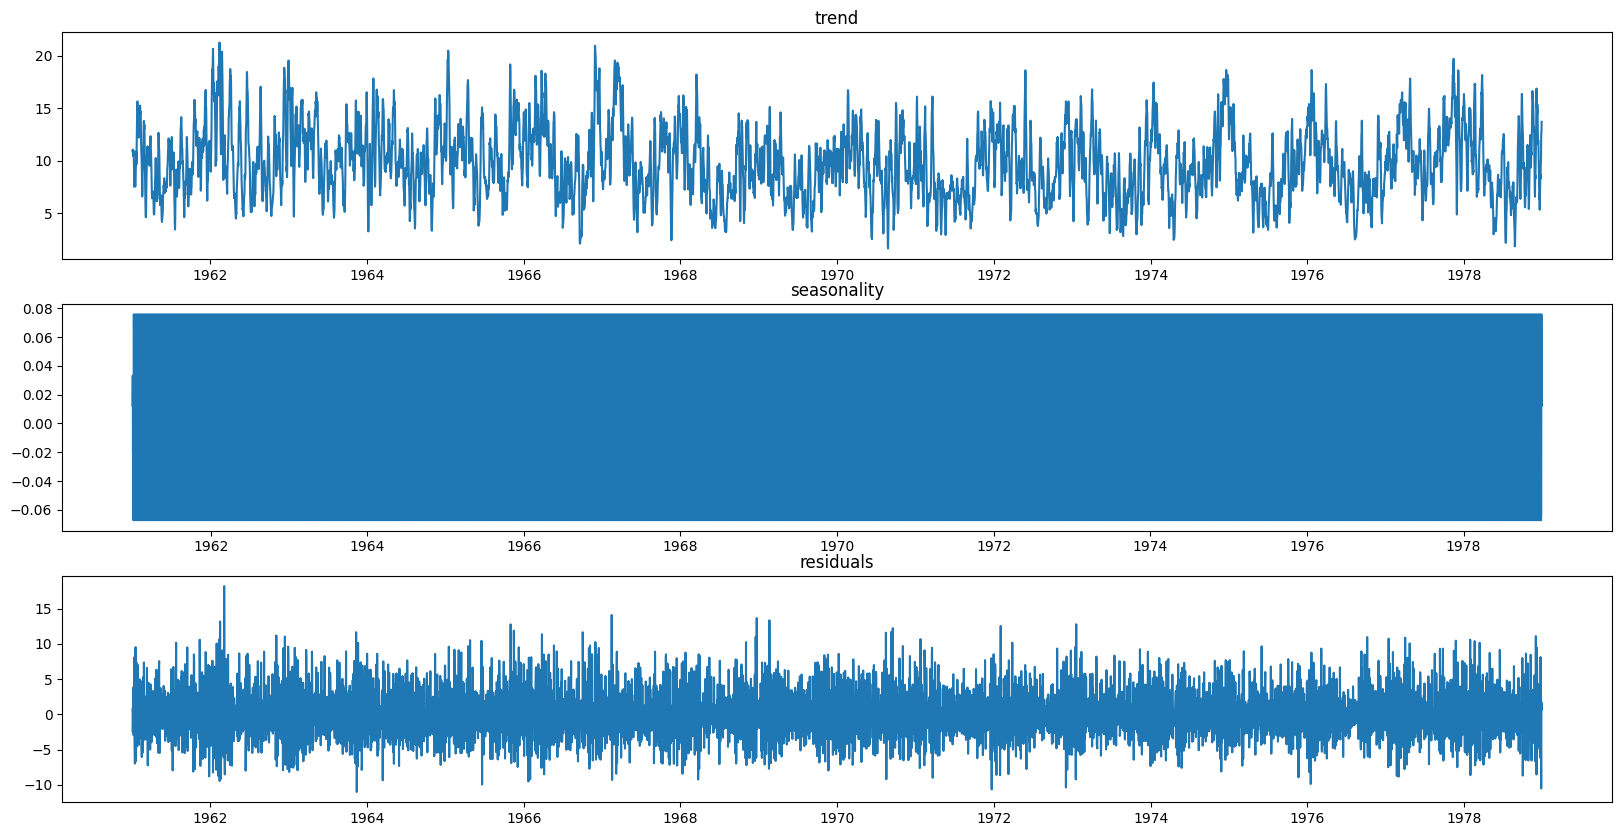

In [12]:
# import the necessary module
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series into its trend, seasonal and residuals components
result_decompose = seasonal_decompose(df['WIND'], model='additive')
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid

# plot every component
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(trend)
plt.title('trend')

plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')

plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')

In [21]:
# we will forecast the last 10 days

testing_timeframe = 10

train = df[:-testing_timeframe]
test  = df[-testing_timeframe:]
print('training set (past data): ', len(train))
print('test set (days to be forecasted ahead): ', len(test))

training set (past data):  6564
test set (days to be forecasted ahead):  10


In [22]:
# import necessary modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# define function that returns the ACF and PACF plots for a given time series
def autocorrelation_plots(timeseries, description, n_lags):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Partial Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.show()

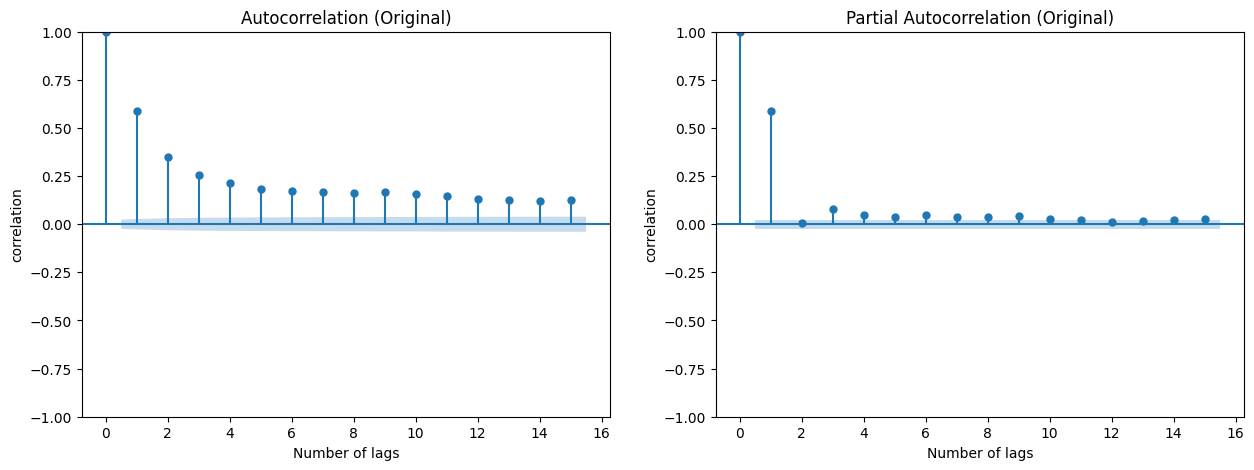

In [23]:
autocorrelation_plots(train['WIND'],'Original',15)

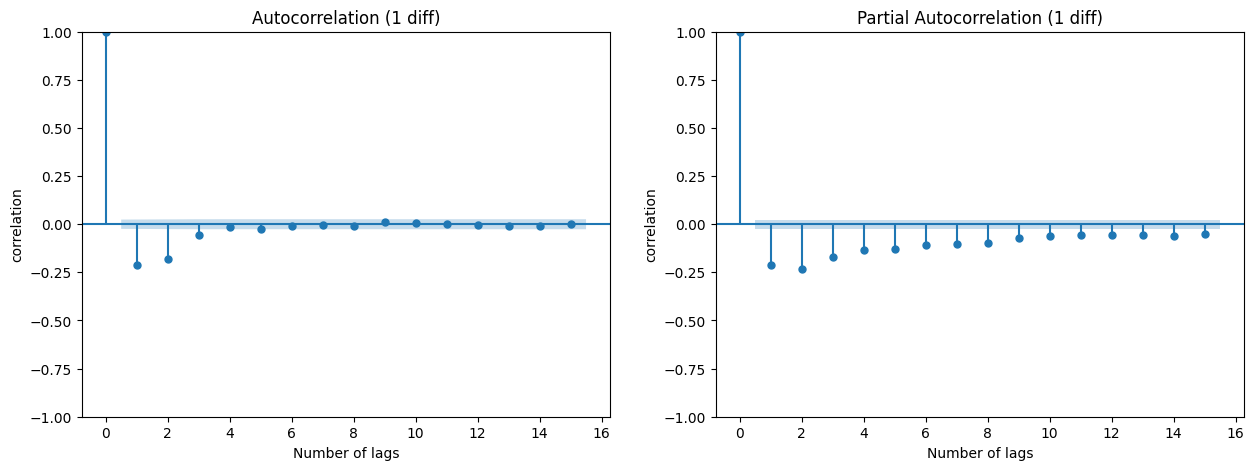

In [25]:
autocorrelation_plots(train['WIND'].diff().dropna(),'1 diff',15)

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# create and fit the model
model_fit = SARIMAX(train['WIND'], order = (1,0,5)).fit()

print(model_fit.summary())
print('\n')
# create forecasts on training set (to evaluate how the model behaves to known-training data)
forecasts_on_train = model_fit.predict()

# create forecasts on test set (to evaluate how the model behaves to unknown-test data)
forecasts_on_test  = model_fit.forecast(len(test))

# calculate the root mean squared error on the test set
RMSE = np.sqrt(mean_squared_error(test['WIND'], forecasts_on_test))

# print the AIC and RMSE
print('AIC: ' , model_fit.aic)
print('RMSE: ', RMSE)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   WIND   No. Observations:                 6564
Model:               SARIMAX(1, 0, 5)   Log Likelihood              -18391.155
Date:                Wed, 30 Oct 2024   AIC                          36796.309
Time:                        08:03:49   BIC                          36843.834
Sample:                    01-01-1961   HQIC                         36812.739
                         - 12-21-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2775.287      0.000       0.999       1.000
ma.L1         -0.4326      0.012    -36.891      0.000      -0.456      -0.410
ma.L2         -0.2929      0.013    -23.234      0.0

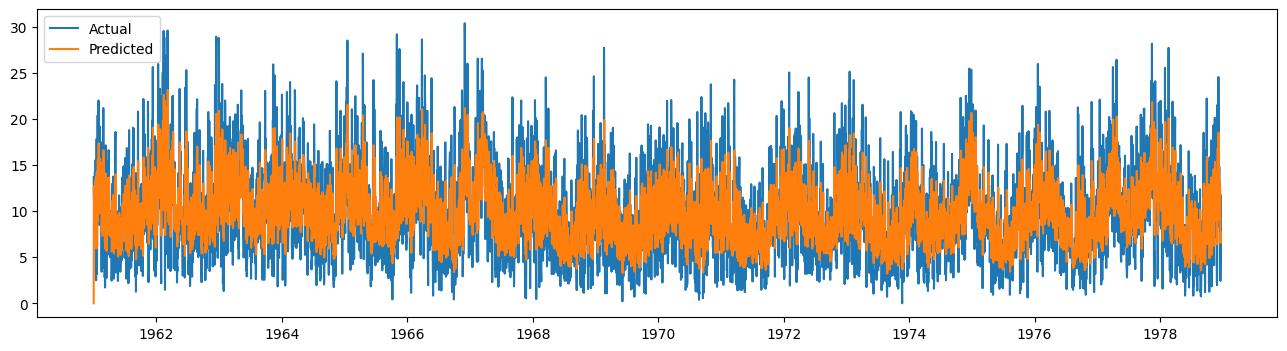

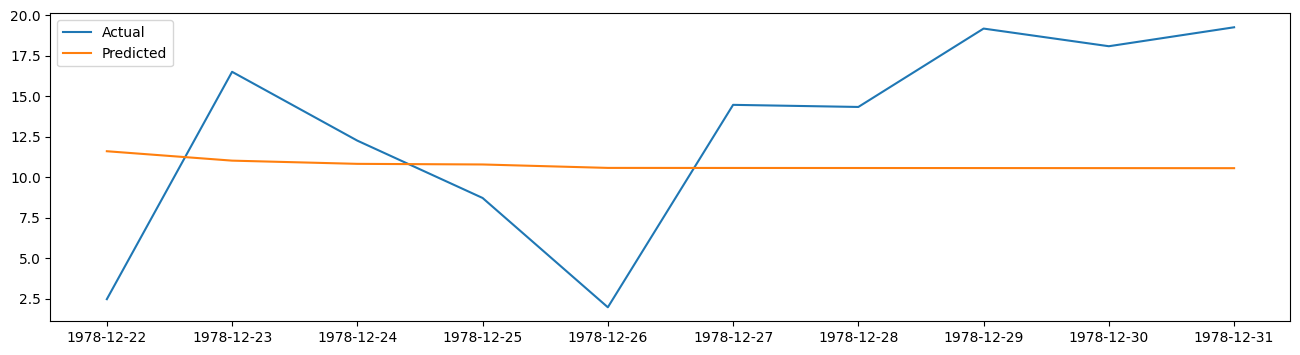

In [27]:
# on train data
plt.figure(figsize=(16,4))
plt.plot(train['WIND'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.plot(test['WIND'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

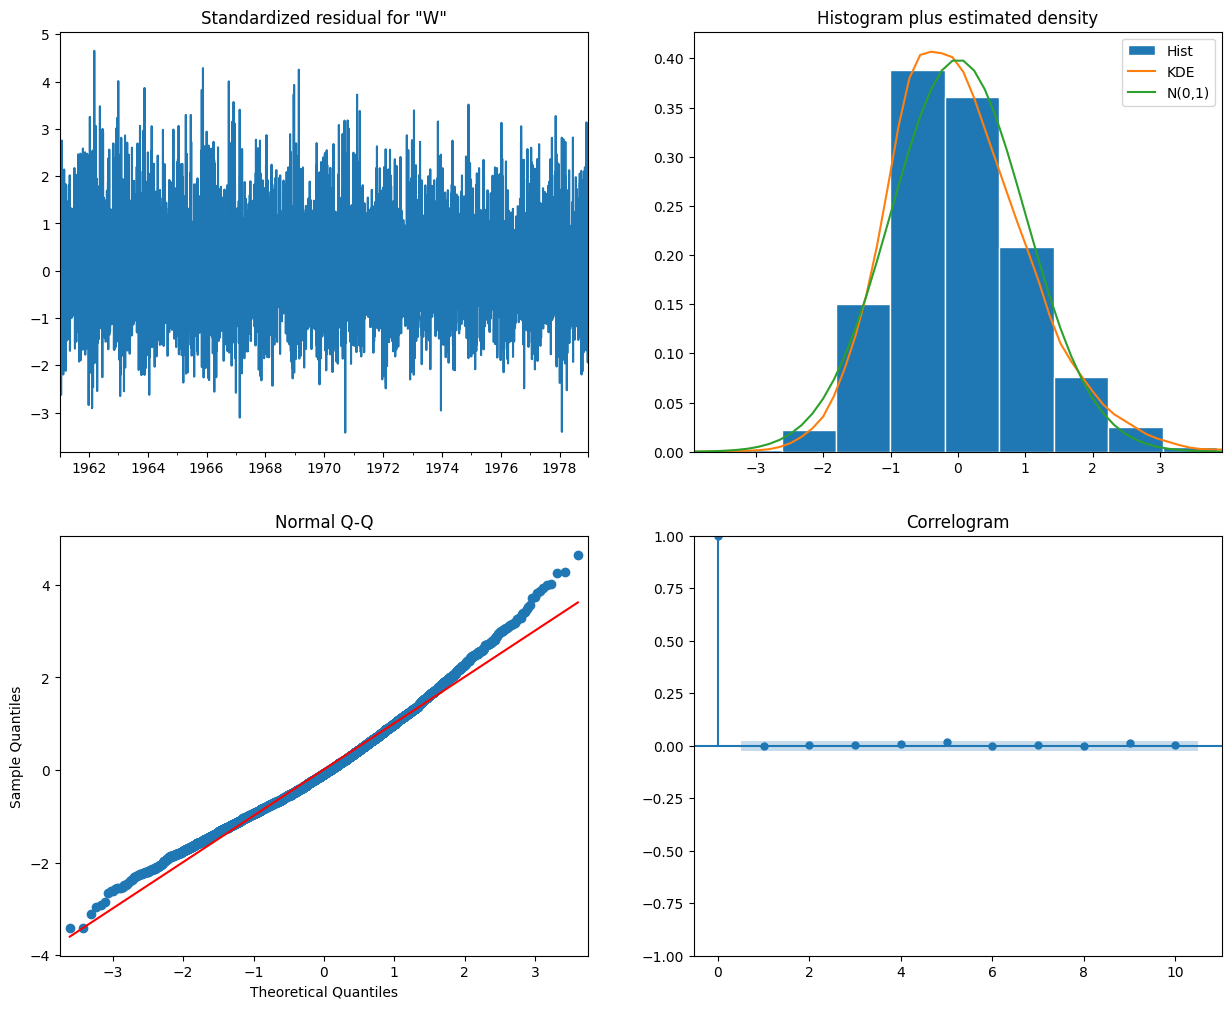

In [29]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [30]:
sarimax = SARIMAX(train['WIND'],
                    order = (1,0,5),
                    seasonal_order = (1,1,0,8)
                   ).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [31]:
forecasts_on_train = sarimax.predict()

# create forecasts on test set (to evaluate how the model behaves to unknown-test data)
forecasts_on_test  = sarimax.forecast(len(test))

# calculate the root mean squared error on the test set
RMSE = np.sqrt(mean_squared_error(test['WIND'], forecasts_on_test))

# print the AIC and RMSE
print('AIC: ' , sarimax.aic)
print('RMSE: ', RMSE)

AIC:  39233.50402003038
RMSE:  6.2727923802296335


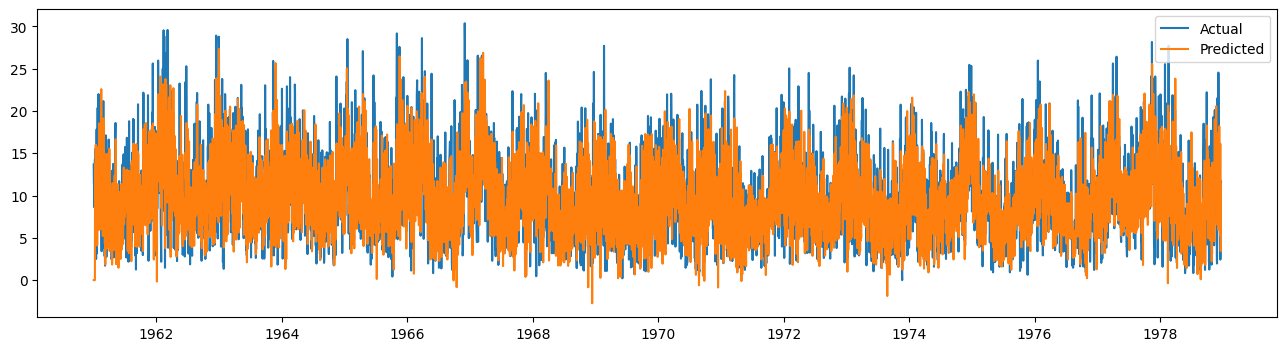

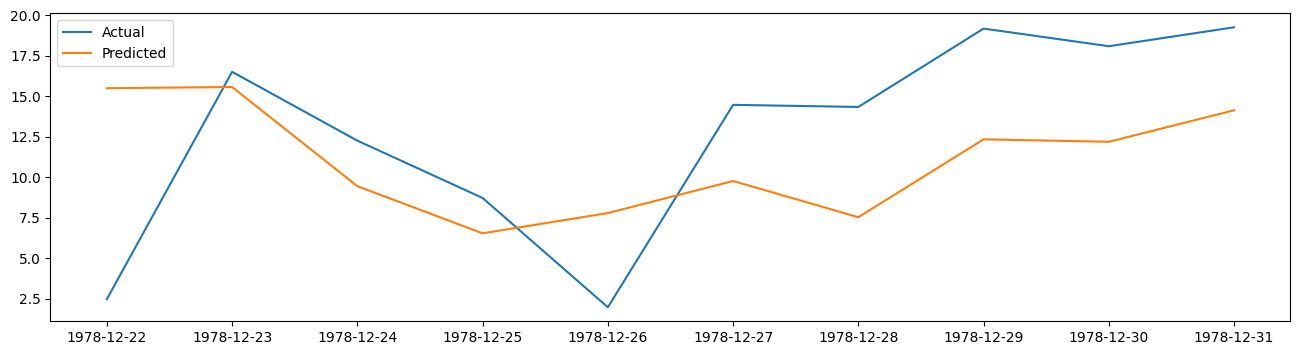

In [32]:
plt.figure(figsize=(16,4))
plt.plot(train['WIND'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.plot(test['WIND'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

In [33]:
# define the exogenous variables
exog_var_train = train[['RAIN','T.MAX','T.MIN','T.MIN.G']].ffill()
exog_var_test  = test[['RAIN','T.MAX','T.MIN','T.MIN.G']].ffill()

# create and fit the model
model_fit = SARIMAX(train['WIND'],
                    order = (1,0,5),
                    seasonal_order = (1,1,0,8),
                    exog = exog_var_train
                   ).fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               WIND   No. Observations:                 6564
Model:             SARIMAX(1, 0, 5)x(1, 1, [], 8)   Log Likelihood              -19362.795
Date:                            Wed, 30 Oct 2024   AIC                          38749.589
Time:                                    08:11:23   BIC                          38831.047
Sample:                                01-01-1961   HQIC                         38777.751
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RAIN           0.0492      0.010      4.969      0.000       0.030       0.069
T.MAX          0.0079      0.025   

In [34]:
forecasts_on_train = model_fit.predict()

# create forecasts on test set (to evaluate how the model behaves to unknown-test data)
forecasts_on_test  = model_fit.forecast(len(test), exog = exog_var_test)

# calculate the root mean squared error on the test set
RMSE = np.sqrt(mean_squared_error(test['WIND'], forecasts_on_test))

# print the AIC and RMSE
print('AIC: ' , model_fit.aic)
print('RMSE: ', RMSE)

AIC:  38749.589013410674
RMSE:  5.590099431845111


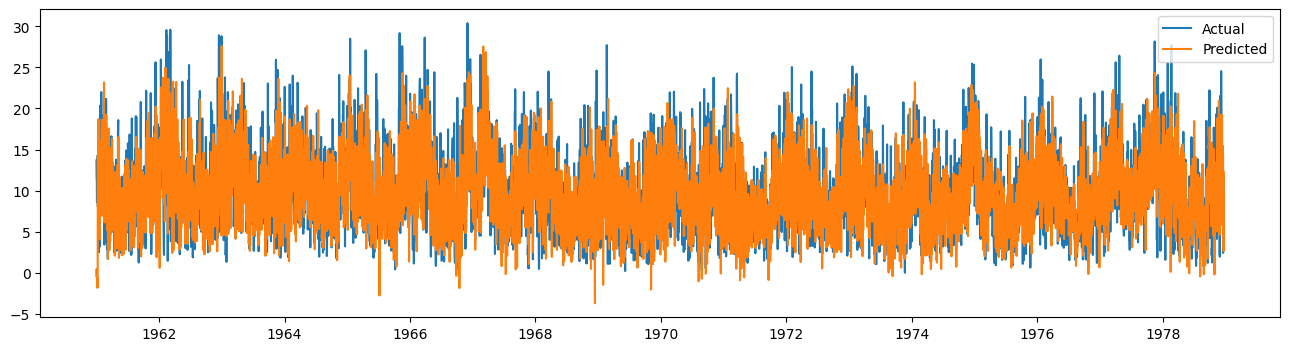

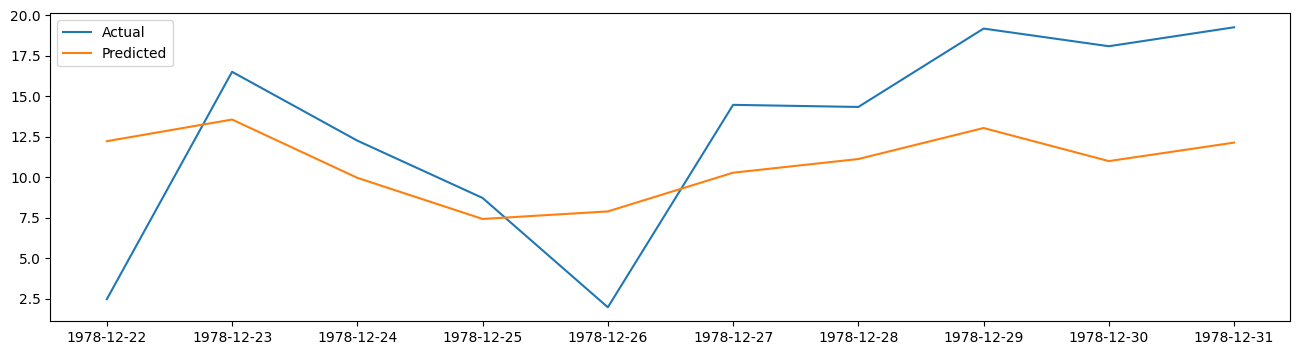

In [35]:

#plot on train data
plt.figure(figsize=(16,4))
plt.plot(train['WIND'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.plot(test['WIND'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

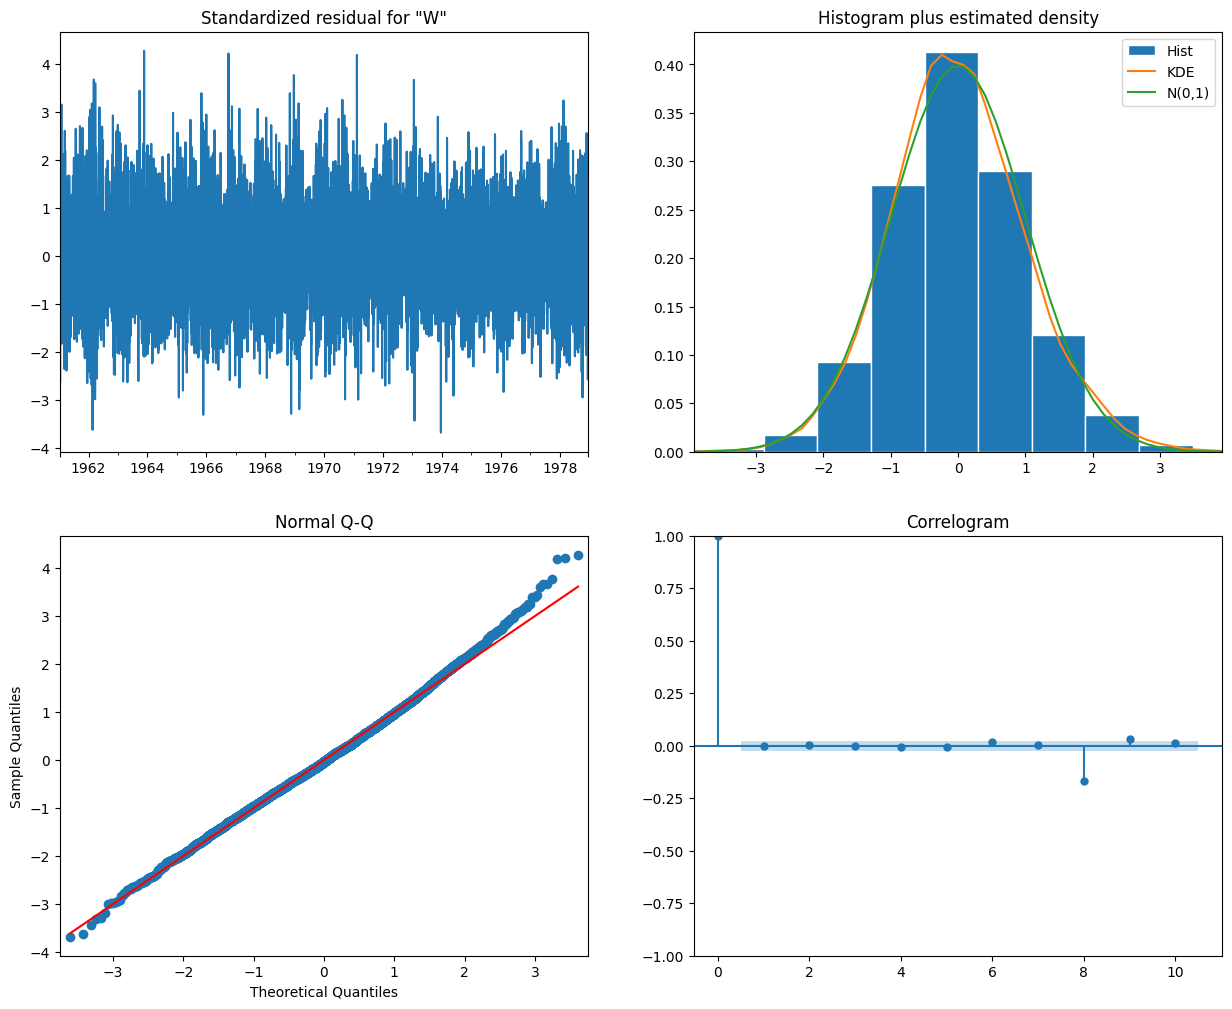

In [36]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
# Standardized residual: There are no obvious patterns in the residuals.
# Histogram plus kde estimate: The KDE curve should be very similar to the normal distribution.
# Normal Q-Q: Most of the data points should lie on the straight line.
# Correlogram: 95% of correlations for lag greater than one should not be significant.